In [1]:
import os
import glob
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.io import read_image
from itertools import chain

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from PIL import Image

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_fscore_support

from torch import nn, optim
from pathlib import Path
from tqdm import tqdm
import random
from copy import deepcopy
import torch.nn.functional as F

from collections import OrderedDict
import cv2

In [2]:
# from tempfile import TemporaryDirectory
cudnn.benchmark = True
# import pdb

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
class AllDataset(Dataset):
    def __init__(self, img_dir, annotations, transform=None):
        """
        Naive implementation:
        List all the images in the given directory (trainset/testset)
        
        For all subfolder in root:
            For each image in the subfolder:
                Add image path to the list
        """
        self.img_dir = img_dir
        self.annotations = pd.read_csv(annotations)
        self.transform = transform
        
        self.img_paths = [glob.glob(os.path.join(img_dir + '/' + subfolder, '*.jpg')) for subfolder in os.listdir(img_dir)]
        self.img_paths = list(chain.from_iterable(self.img_paths))
        
        
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        """
        Read the image, extract the pid from the image path
        Locate the corresponding label, gender, lymph_count
        And return all of them
        
        To do: what to do with DOB
        options: year, or the unix age
        """
        image = read_image(self.img_paths[idx])
        PID = self.img_paths[idx].split('/')[-2]
        label = list(self.annotations[self.annotations['ID'] == PID]['LABEL'])[0]
        gender = list(self.annotations[self.annotations['ID'] == PID]['GENDER'])[0]
#         print(type(gender)) -- bug: it should be string, but the dataloader returns a tuple ('M', )
        lymph_count = list(self.annotations[self.annotations['ID'] == PID]['LYMPH_COUNT'])[0]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, gender, lymph_count, PID

In [5]:
class BagDataset(Dataset):
    """This dataset include the images and metadata of a list of subjects"""

    def __init__(self, img_dir, data_df, transform=None):
        """
        Args:
            img_dir: (str) path to the images directory.
            data_df: (DataFrame) list of subjects used.
            transform: Optional, transformations applied to the tensor
        """
        self.img_dir = img_dir
        self.transform = transform
        self.data_df = data_df

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        """
        Args:
            idx: (int) the index of the subject/session whom data is loaded.
        Returns:
            sample: (dict) corresponding data described by the following keys:
                images: (List) List with image tensors
                label: (int) the diagnosis code
                id: (str) ID of the participant
                gender: (str) 'M' or 'F'
                age: (int) age
                lymph_count: (int) lymph count
        """

        label = self.data_df.loc[idx, 'LABEL']
        age = self.data_df.loc[idx, 'AGE']
        gender = self.data_df.loc[idx, 'GENDER']
        lymph_count = self.data_df.loc[idx, 'LYMPH_COUNT']

        id = self.data_df.loc[idx, 'ID']
        folder_name = os.path.join(self.img_dir, id)
        images = []
        for filename in Path(folder_name).glob('*'):
            image = read_image(str(filename))
            
            if self.transform:
                image = self.transform(image)
            
            images.append(image)

        sample = {'images': images, 'label': label,
                  'id': id, 'gender': gender, 'age': age,
                  'lymph_count': lymph_count}
        return sample

In [6]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class FCLayer(nn.Module):
    def __init__(self, in_size, out_size=1):
        super(FCLayer, self).__init__()
        self.fc = nn.Sequential(nn.Linear(in_size, out_size))
    def forward(self, feats):
        x = self.fc(feats)
        return feats, x

class IClassifier(nn.Module):
    def __init__(self, feature_extractor, feature_size, output_class):
        super(IClassifier, self).__init__()
        
        self.feature_extractor = feature_extractor      
        self.fc = nn.Linear(feature_size, output_class)
        
        
    def forward(self, x):
        device = x.device
        feats = self.feature_extractor(x) # N x K
        c = self.fc(feats.view(feats.shape[0], -1)) # N x C
        return feats.view(feats.shape[0], -1), c

class BClassifier(nn.Module):
    def __init__(self, input_size, output_class, dropout_v=0.0, nonlinear=True, passing_v=False): # K, L, N
        super(BClassifier, self).__init__()
        if nonlinear:
            self.q = nn.Sequential(nn.Linear(input_size, 128), nn.ReLU(), nn.Linear(128, 128), nn.Tanh())
        else:
            self.q = nn.Linear(input_size, 128)
        if passing_v:
            self.v = nn.Sequential(
                nn.Dropout(dropout_v),
                nn.Linear(input_size, input_size),
                nn.ReLU()
            )
        else:
            self.v = nn.Identity()
        
        ### 1D convolutional layer that can handle multiple class (including binary)
        self.fcc = nn.Conv1d(output_class, output_class, kernel_size=input_size)  
        
    def forward(self, feats, c): # N x K, N x C
        device = feats.device
        V = self.v(feats) # N x V, unsorted
        Q = self.q(feats).view(feats.shape[0], -1) # N x Q, unsorted
        
        # handle multiple classes without for loop
        _, m_indices = torch.sort(c, 0, descending=True) # sort class scores along the instance dimension, m_indices in shape N x C
        m_feats = torch.index_select(feats, dim=0, index=m_indices[0, :]) # select critical instances, m_feats in shape C x K 
        q_max = self.q(m_feats) # compute queries of critical instances, q_max in shape C x Q
        A = torch.mm(Q, q_max.transpose(0, 1)) # compute inner product of Q to each entry of q_max, A in shape N x C, each column contains unnormalized attention scores
        A = F.softmax( A / torch.sqrt(torch.tensor(Q.shape[1], dtype=torch.float32, device=device)), 0) # normalize attention scores, A in shape N x C, 
        B = torch.mm(A.transpose(0, 1), V) # compute bag representation, B in shape C x V
                
        B = B.view(1, B.shape[0], B.shape[1]) # 1 x C x V
        C = self.fcc(B) # 1 x C x 1
        C = C.view(1, -1)
        return C, A, B 
    

class FullNet(nn.Module):
    def __init__(self, i_classifier, b_classifier, feature_extractor):
        super(FullNet, self).__init__()
        self.feature_extractor = feature_extractor
#         self.resnet18 = models.resnet18(weights=None)
#         if PATH:
#             self.resnet18.load_state_dict(torch.load(PATH))
#         self.resnet18.fc = Identity()
        self.i_classifier = i_classifier
        self.b_classifier = b_classifier
#         self.fc1 = nn.Linear(2, 128)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(128, 128)
#         self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(64, 1)
            
    def forward(self, x):
        feats = self.feature_extractor(x)
#         max_value, min_value = torch.max(feats), torch.min(feats)
#         feats = (feats - min_value) / (max_value - min_value)
        
        feats, classes = self.i_classifier(feats)
        prediction_bag, A, B = self.b_classifier(feats, classes)
#         max_prediction, index = torch.max(classes, 0)
#         output = self.relu(self.fc1(torch.tensor([[prediction_bag, max_prediction]]).to(device)))
#         output = self.relu(self.fc2(output))
#         output = self.relu(self.fc3(output))
#         output = self.relu(self.fc4(output))
        
        return classes, prediction_bag, A, B

In [7]:
# -- Encoder - Decoder
class CNN_Encoder(nn.Module):
    def __init__(self, output_size, input_size=(3, 64, 64)):
        super(CNN_Encoder, self).__init__()

        self.input_size = input_size
        self.channel_mult = 16

        #convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(3, self.channel_mult*1, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.channel_mult*1, self.channel_mult*2, 4, 2, 1),
            nn.BatchNorm2d(self.channel_mult*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.channel_mult*2, self.channel_mult*4, 4, 2, 1),
            nn.BatchNorm2d(self.channel_mult*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.channel_mult*4, self.channel_mult*8, 4, 2, 1),
            nn.BatchNorm2d(self.channel_mult*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.channel_mult*8, self.channel_mult*16, 3, 2, 1),
            nn.BatchNorm2d(self.channel_mult*16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.channel_mult*16, self.channel_mult*16, 3, 1, 1),
            nn.BatchNorm2d(self.channel_mult*16),
            nn.LeakyReLU(0.2, inplace=True)

        )

        self.flat_fts = self.get_flat_fts(self.conv)

        self.linear = nn.Sequential(
            nn.Linear(self.flat_fts, int(self.flat_fts/2)),
            nn.Linear(int(self.flat_fts/2), output_size),
            nn.BatchNorm1d(output_size),
            nn.LeakyReLU(0.2),
        )

    def get_flat_fts(self, fts):
        f = fts(Variable(torch.ones(1, 3, 64, 64)))
        return int(np.prod(f.size()[1:]))

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, self.flat_fts)
        return self.linear(x)

class CNN_Encoder_Resnet(nn.Module):
    def __init__(self, output_size, input_size=(3, 64, 64)):
        super(CNN_Encoder_Resnet, self).__init__()
        self.resnet = models.resnet18()
        self.flat_fts = 512
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.flat_fts, int(self.flat_fts/2)),
            nn.Linear(int(self.flat_fts/2), output_size),
            nn.BatchNorm1d(output_size),
            nn.LeakyReLU(0.2),
        )

    def get_flat_fts(self, fts):
        f = fts(Variable(torch.ones(1, 3, 64, 64)))
        return int(np.prod(f.size()[1:]))

    def forward(self, x):
        x = self.resnet(x)
        return x

class CNN_Decoder(nn.Module):
    def __init__(self, embedding_size=256, input_size=(3, 64, 64)):
        super(CNN_Decoder, self).__init__()
        self.input_height = input_size[1]
        self.input_width = input_size[2]
        self.input_dim = embedding_size
        self.channel_mult = 16
        self.output_channels = input_size[0]
        self.fc_output_dim = 4096

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, self.fc_output_dim),
            nn.BatchNorm1d(self.fc_output_dim),
            nn.ReLU(True)
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.fc_output_dim, self.channel_mult*8,
                                4, 1, 0, bias=False),  # Adjusted kernel, stride, padding
            nn.BatchNorm2d(self.channel_mult*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.channel_mult*8, self.channel_mult*4,
                                4, 2, 1, bias=False),  # Adjusted kernel, stride, padding
            nn.BatchNorm2d(self.channel_mult*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.channel_mult*4, self.channel_mult*2,
                                4, 2, 1, bias=False),  # Adjusted kernel, stride, padding
            nn.BatchNorm2d(self.channel_mult*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.channel_mult*2, self.channel_mult,
                                4, 2, 1, bias=False),  # Adjusted kernel, stride, padding
            nn.BatchNorm2d(self.channel_mult),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.channel_mult, self.output_channels,
                                4, 2, 1, bias=False),  # Adjusted kernel, stride, padding
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.fc_output_dim, 1, 1)
        x = self.deconv(x)
        return x

In [8]:
class Network(nn.Module):
    def __init__(self, embedding_size=256):
        super(Network, self).__init__()
        self.encoder = CNN_Encoder_Resnet(embedding_size) # , input_size=(3, 224, 224))
        self.decoder = CNN_Decoder(embedding_size) #, input_size=(3, 224, 224))

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return z, self.decode(z)

In [9]:
def load_my_state_dict(model, state_dict):

    own_state = model.state_dict()
    for name, param in state_dict.items():
        if name not in own_state:
             continue
        if isinstance(param, nn.Parameter):
            # backwards compatibility for serialized parameters
            param = param.data
        own_state[name].copy_(param)

In [10]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.RandomRotation(5)
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [11]:
enc_dataset = AllDataset(img_dir='/kaggle/input/classification-dataset/dlmi-lymphocytosis-classification/trainset',
                        annotations='/kaggle/input/classification-dataset/dlmi-lymphocytosis-classification/clinical_annotation.csv',
                        transform=transform)

VAL_SPLIT_RATIO = 0.2

enc_dataset_size = len(enc_dataset)
enc_dataset_indices = list(range(enc_dataset_size))

val_split_index = int(np.floor(VAL_SPLIT_RATIO * enc_dataset_size))

train_idx, val_idx = enc_dataset_indices[val_split_index:], enc_dataset_indices[:val_split_index]

enc_train_sampler = SubsetRandomSampler(train_idx)
enc_val_sampler = SubsetRandomSampler(val_idx)

In [12]:
enc_trainloader = DataLoader(dataset=enc_dataset, batch_size=128, sampler=enc_train_sampler, num_workers=4)

enc_valloader = DataLoader(dataset=enc_dataset, batch_size=128, sampler=enc_val_sampler, num_workers=4)

In [13]:
# enc_model = Network()

# enc_model = enc_model.to(device)

In [14]:
# enc_criterion = nn.MSELoss()
# enc_optimizer = torch.optim.Adam(enc_model.parameters(), lr=1e-2) # , betas=(0.9, 0.999), weight_decay=1e-4)
# # optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)
# # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100, 0)
# enc_scheduler = torch.optim.lr_scheduler.MultiStepLR(enc_optimizer, milestones=[10,20,40], gamma=0.1)

In [15]:
# def test_enc(model, dataloader, criterion):
#     model.eval()
#     with torch.no_grad():
#         total_loss = 0
#         for images, _, _, _, _ in dataloader:
#             images = images.to(device)
#             _, recons = model(images)
#             loss = 100 * criterion(images, recons)
            
#             total_loss += loss.item()
        
#         print("Test Loss: {}".format(total_loss / len(dataloader)))
            

In [16]:
# def train_enc(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler):
#     for epoch in range(epochs):
#         model.train()
#         epoch_loss = 0
#         for images, _, _, _, _ in train_loader:
#             images = images.to(device)
#             _, recons = model(images)
# #             print(recons.shape)
#             loss = 100 * criterion(images, recons)
            
#             epoch_loss += loss.item()
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
        
#         print("Train Loss: {}".format(epoch_loss / len(train_loader)))
        
# #         test_enc(model, train_loader, criterion)
#         test_enc(model, val_loader, criterion)
        
#         if epoch == 49:
#             PATH = '/kaggle/working/enc50.pth'
#             torch.save({
#                 'epoch': epoch+1,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#             }, PATH)
#         if epoch == 99:
#             PATH = '/kaggle/working/enc100.pth'
#             torch.save({
#                 'epoch': epoch+1,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#             }, PATH)
# #         scheduler.step()

In [112]:
# train_enc(enc_model, enc_trainloader, enc_valloader, 100, enc_criterion, enc_optimizer, enc_scheduler)

In [17]:
# images, _, _, _, _ = next(iter(enc_valloader))
# test_image = images[1].unsqueeze(0)

In [18]:
# with torch.no_grad():
#     test_image = test_image.to(device)
#     z, recon_image = enc_model(test_image)
# #
# print(z.shape, recon_image.shape)

In [19]:
# input_im = test_image.squeeze(0).detach().cpu().numpy()
# plt.imshow(np.moveaxis(input_im, 0, 2))

In [20]:
# out_np = recon_image.squeeze(0).detach().cpu().numpy()
# plt.imshow(np.moveaxis(out_np,0,2))

In [21]:
# !ls /kaggle/input/simclr_pretrained_r18/pytorch/r18_online/1/simclr_pretrained.pth.tar

In [22]:
feature_extractor = CNN_Encoder_Resnet(256)
# feature_extractor.resnet.fc = nn.Sequential(nn.Linear(512, 256), nn.Linear(256, 256))

# local_checkpoint = torch.load('/kaggle/working/enc100.pth')['model_state_dict']
# feature_extractor.load_state_dict(local_checkpoint)

In [23]:
# new_state_dict = OrderedDict()
# count = 0
# for k, v in local_checkpoint.items():
#     count += 1
#     name = k[8:] # remove `module.`
# #     print(name)
#     new_state_dict[name] = v
    

# load_my_state_dict(feature_extractor, new_state_dict)
# # print(count)

In [24]:
# with torch.no_grad():
# #     feature_extractor.eval()
#     test_image = test_image
#     z = feature_extractor(test_image)
# #
# print(z[:10])

In [25]:
# PATH = "/kaggle/input/simclr_pretrained_r18/pytorch/r18_online/1/simclr_pretrained.pth.tar"
# resnet = models.resnet50(weights=None)
# resnet.fc = nn.Sequential(nn.Linear(2048, 512),nn.ReLU(), nn.Linear(512, 256))

# # resnet18 = nn.DataParallel(resnet18)
# # checkpoint = torch.load(PATH, map_location=torch.device('cpu'))['state_dict']
# # checkpoint = torch.load(PATH)['state_dict']
# # resnet18.load_state_dict(torch.load(PATH, map_location=torch.device('cpu'))['state_dict'])
# # resnet18.load_state_dict(checkpoint)

In [26]:
# temp_net = models.resnet50()
# print(temp_net)

In [27]:
# new_state_dict = OrderedDict()
# for k, v in checkpoint.items():
#     name = k[14:] # remove `module.`
#     new_state_dict[name] = v
    

# load_my_state_dict(resnet, new_state_dict)

In [28]:
img_path = '/kaggle/input/classification-dataset/dlmi-lymphocytosis-classification/trainset'
train_df = pd.read_csv('/kaggle/input/classification-dataset/train_set.csv')
val_df = pd.read_csv('/kaggle/input/classification-dataset/val_set.csv')

In [29]:
# class GaussianBlur(object):
#     # Implements Gaussian blur as described in the SimCLR paper
#     def __init__(self, kernel_size, min=0.1, max=2.0):
#         self.min = min
#         self.max = max
#         # kernel size is set to be 10% of the image height/width
#         self.kernel_size = kernel_size

#     def __call__(self, sample):
#         sample = np.array(sample)

#         # blur the image with a 50% chance
#         prob = np.random.random_sample()

#         if prob < 0.5:
# #            print(self.kernel_size)
#             sigma = (self.max - self.min) * np.random.random_sample() + self.min
#             sample = cv2.GaussianBlur(sample, (self.kernel_size, self.kernel_size), sigma)

#         return sample

In [30]:
# train_transforms = transforms.Compose([transforms.ToPILImage(),
#                                        transforms.Resize(128),
# #                                        transforms.RandomResizedCrop(128),
# #                                        transforms.RandomHorizontalFlip(),
# #                                        transforms.RandomGrayscale(p=0.2),
# #                                        GaussianBlur(kernel_size=int(0.06 * 224)),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#                                       ])

train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.RandomRotation(5)
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(64),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [31]:
train_dataset = BagDataset(img_path, train_df, train_transforms)
train_loader = DataLoader(dataset=train_dataset, batch_size=1, num_workers=4, shuffle=True)

val_dataset = BagDataset(img_path, val_df, val_transforms)
val_loader = DataLoader(dataset=val_dataset, batch_size=1, num_workers=4)

In [96]:
num_feats = 256
i_classifier = FCLayer(num_feats, 1)
b_classifier = BClassifier(input_size=num_feats, output_class=1)
model = FullNet(i_classifier, b_classifier, feature_extractor)

# load pretrained model
local_checkpoint = torch.load('/kaggle/working/frozen_enc_best.pth')
model.load_state_dict(local_checkpoint['model_state_dict'])
# model = nn.DataParallel(model, device_ids=[0, 1])
model = model.to(device)

# print(model)

In [97]:
# # freeze the feature extractor
extractor_params = [param for name, param in model.named_parameters() if 'feature_extractor' in name]
normal_params = [param for name, param in model.named_parameters() if not 'feature_extractor' in name]
# for name, param in model.named_parameters():
#     if 'feature_extractor' in name:
#         param.requires_grad = False

In [98]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam([{'params': extractor_params, 'lr': 1e-5}, {'params': normal_params, 'lr': 1e-2}], betas=(0.5, 0.9), weight_decay=1e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100, 0)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80,100], gamma=0.1)

In [99]:
# def optimal_thresh(fpr, tpr, thresholds, p=0):
#     loss = (fpr - tpr) - p * tpr / (fpr + tpr + 1)
#     idx = np.argmin(loss, axis=0)
#     return fpr[idx], tpr[idx], thresholds[idx]

# def five_scores(bag_labels, bag_predictions):
# #     print(bag_labels, bag_predictions)
#     fpr, tpr, threshold = roc_curve(bag_labels, bag_predictions, pos_label=1)
#     fpr_optimal, tpr_optimal, threshold_optimal = optimal_thresh(fpr, tpr, threshold)
#     auc_value = roc_auc_score(bag_labels, bag_predictions)
#     this_class_label = np.array(bag_predictions)
#     this_class_label[this_class_label>=threshold_optimal] = 1
#     this_class_label[this_class_label<threshold_optimal] = 0
#     bag_predictions = this_class_label
#     precision, recall, fscore, _ = precision_recall_fscore_support(bag_labels, bag_predictions, average='binary')
#     accuracy = 1- np.count_nonzero(np.array(bag_labels).astype(int)- bag_predictions.astype(int)) / len(bag_labels)
#     return accuracy, auc_value, precision, recall, fscore

In [100]:
def test(model, dataloader):
    bag_labels = []
    bag_predictions = []
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            images, label = data['images'], data['label']

            images = torch.cat(images, dim=0).to(device)
    #             label = label.to(device)

            classes, bag_prediction, _, _ = model(images)
#             bag_prediction = model(images)

            bag_labels.append(label.numpy())
            bag_predictions.append(torch.sigmoid(bag_prediction).cpu().squeeze().numpy())

#     five_scores_bag_predictions = bag_predictions
    bag_predictions = [0 if prediction < 0.5 else 1 for prediction in bag_predictions]
#     print(bag_labels, bag_predictions)

    balanced_acc = balanced_accuracy_score(bag_labels, bag_predictions)
    normal_acc = accuracy_score(bag_labels, bag_predictions)
        
    # --- Printing evaluation numbers every 5 epochs ---
#         correct = 0
#         for i in range(len(bag_predictions)):
#             if bag_predictions[i] == bag_labels[i]:
#                 correct += 1
    print("Balanced Acc: {:.4f} Normal Acc: {:.4f}".format(balanced_acc, normal_acc))
    return balanced_acc
    
#     acc, auc_value, precision, recall, fscore = five_scores(bag_labels, five_scores_bag_predictions)
#     print(acc, auc_value, precision, recall, fscore)
    

In [101]:
test_df = pd.read_csv('/kaggle/input/classification-dataset/test_set.csv')
test_path = '/kaggle/input/classification-dataset/dlmi-lymphocytosis-classification/testset'
test_dataset = BagDataset(test_path, test_df, val_transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, num_workers=4)

In [103]:
# preds = []
# model.eval()
# with torch.no_grad():
#     for data in test_loader:
#         images, label = data['images'], data['label']

#         images = torch.cat(images, dim=0).to(device)

#         classes, bag_prediction, _, _ = model(images)

#         preds.append(torch.sigmoid(bag_prediction).cpu().squeeze().numpy())

In [104]:
# preds = [0 if pred < 0.5 else 1 for pred in preds]

In [105]:
# # preds = rf.predict(X_test)

# data = {'ID': test_df['ID'], 'Predicted': preds}
# output = pd.DataFrame(data=data)

In [106]:
# output.to_csv('/kaggle/working/sample_submission.csv', index=False)

In [107]:
# test(model, val_loader)

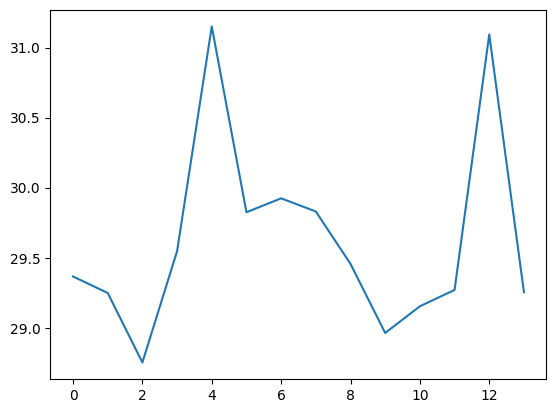

<Figure size 640x480 with 0 Axes>

In [108]:
plt.plot(train_losses)
plt.show()
plt.savefig('/kaggle/working/loss_curve.png')

In [109]:
train_losses = []
val_losses = []
accuracies = []
bal_accs = []
roc_accs = []

best_acc = 0.0
for epoch in range(150):
    epoch_loss = 0.0
    model.train()
    print("-- training: epoch {}".format(epoch+1))
#     ground_labels = []
#     bag_predictions = []
#     max_predictions = []
    for data in train_loader:
        images, label = data['images'], data['label']
#         ground_labels.append(label)
        images = torch.cat(images, dim=0).to(device)
        label = label.to(device)


        classes, bag_prediction, _, _ = model(images) # n X L
        max_prediction, index = torch.max(classes, 0)
#         print(bag_prediction, max_prediction)
#         bag_predictions.append(bag_prediction)
#         max_predictions.append(max_prediction)
#         torch.cuda.empty_cache()

#         bag_predictions = torch.cat(bag_predictions, dim=0)
#         max_predictions = torch.cat(max_predictions, dim=0)
        loss_bag = criterion(bag_prediction.view(1, -1), label.view(1, -1).float())
        loss_max = criterion(max_prediction.view(1, -1), label.view(1, -1).float())
        
#         prediction = model(images)
#         loss = criterion(prediction.view(1, -1), label.view(1, -1).float())
        weight = 1.0
        if label.item() == 1:
#             print("label: {}".format(label.item()))
            weight_factor = 0.30
        else:
#             print("label: {}".format(label.item()))
            weight_factor = 0.70
        
        loss_total = (0.5*loss_bag + 0.5*loss_max) * weight_factor
#         loss_total = loss * weight_factor
#         print(type(loss_total), loss_total.shape)
        loss_total = loss_total.mean()

        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()  

        epoch_loss += loss_total.item()

    print("Epoch loss: {:.4f}".format(epoch_loss))
    train_losses.append(epoch_loss)
#     test_loss = 0.0
    

    # ------------ Testing ------------
    test(model, train_loader)
    val_acc = test(model, val_loader)
#     bag_labels = []
#     bag_predictions = []
#     model.eval()
#     with torch.no_grad():
#         for data in val_loader:
#             images, label = data['images'], data['label']

#             images = torch.cat(images, dim=0).to(device)
#     #             label = label.to(device)

#             classes, bag_prediction, _, _ = model(images)

#             bag_labels.append(label.numpy())
#             bag_predictions.append(torch.sigmoid(bag_prediction).cpu().squeeze().numpy())

#     bag_predictions = [0 if prediction < 0.5 else 1 for prediction in bag_predictions]
# #     print(bag_labels, bag_predictions)

#     balanced_acc = balanced_accuracy_score(bag_labels, bag_predictions)
#     scikit_acc = accuracy_score(bag_labels, bag_predictions)
#     roc_acc = roc_auc_score(bag_labels, bag_predictions)

#     accuracies.append(scikit_acc)
#     bal_accs.append(balanced_acc)
#     roc_accs.append(roc_acc) 
        
#     # --- Printing evaluation numbers every 5 epochs ---
#     if (epoch+1) % 5 == 0:
#         print("-- testing: epoch {}".format(epoch+1))
# #         correct = 0
# #         for i in range(len(bag_predictions)):
# #             if bag_predictions[i] == bag_labels[i]:
# #                 correct += 1
#         print("Balanced Acc: {:.4f} scikit-acc: {:.4f} roc_score: {:.4f}".format(balanced_acc, scikit_acc, roc_acc))
    
    # --- Save the model every 50 epochs ---
    if (epoch+1) % 50 == 0:
        PATH = '/kaggle/working/frozen_enc_2' + str(epoch+1) + '.pth'
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, PATH)
    
    # --- Save the best model ---
    if val_acc > best_acc:
        best_acc = val_acc
        PATH = '/kaggle/working/frozen_enc_2best.pth'
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, PATH)


#     scheduler.step()

-- training: epoch 1
Epoch loss: 61.1180
Balanced Acc: 0.6403 Normal Acc: 0.6846
Balanced Acc: 0.5478 Normal Acc: 0.6061
-- training: epoch 2
Epoch loss: 64.5068
Balanced Acc: 0.6097 Normal Acc: 0.4692
Balanced Acc: 0.5652 Normal Acc: 0.3939
-- training: epoch 3
Epoch loss: 61.4734
Balanced Acc: 0.5000 Normal Acc: 0.6923
Balanced Acc: 0.5000 Normal Acc: 0.6970
-- training: epoch 4
Epoch loss: 73.8939
Balanced Acc: 0.5000 Normal Acc: 0.6923
Balanced Acc: 0.5000 Normal Acc: 0.6970
-- training: epoch 5
Epoch loss: 59.4562
Balanced Acc: 0.5000 Normal Acc: 0.3077
Balanced Acc: 0.5000 Normal Acc: 0.3030
-- training: epoch 6
Epoch loss: 60.5730
Balanced Acc: 0.6333 Normal Acc: 0.6846
Balanced Acc: 0.5413 Normal Acc: 0.6364
-- training: epoch 7
Epoch loss: 68.0532
Balanced Acc: 0.6500 Normal Acc: 0.6692
Balanced Acc: 0.5109 Normal Acc: 0.5152
-- training: epoch 8
Epoch loss: 68.8368
Balanced Acc: 0.5000 Normal Acc: 0.3077
Balanced Acc: 0.5000 Normal Acc: 0.3030
-- training: epoch 9
Epoch loss:

KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses)
plt.show()

In [ ]:
test_loss = 0.0

bag_labels = []
bag_predictions = []
model.eval()
with torch.no_grad():
    for data in val_loader:
        images, label = data['images'], data['label']

        images = torch.cat(images, dim=0).to(device)
#             label = label.to(device)

        classes, bag_prediction, _, _ = model(images)

        bag_labels.append(label.numpy())
        bag_predictions.append(torch.sigmoid(bag_prediction).cpu().squeeze().numpy())

bag_predictions = [0 if prediction < 0.5 else 1 for prediction in bag_predictions]
print(bag_labels, bag_predictions)

correct = 0
for i in range(len(bag_predictions)):
    if bag_predictions[i] == bag_labels[i]:
        correct += 1
print("Accuracy: {}".format(correct / len(bag_predictions)))

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_fscore_support

In [ ]:
def five_scores(bag_labels, bag_predictions):
    print(bag_labels, bag_predictions)
    fpr, tpr, threshold = roc_curve(bag_labels, bag_predictions, pos_label=1)
    fpr_optimal, tpr_optimal, threshold_optimal = optimal_thresh(fpr, tpr, threshold)
    auc_value = roc_auc_score(bag_labels, bag_predictions)
    this_class_label = np.array(bag_predictions)
    this_class_label[this_class_label>=threshold_optimal] = 1
    this_class_label[this_class_label<threshold_optimal] = 0
    bag_predictions = this_class_label
    precision, recall, fscore, _ = precision_recall_fscore_support(bag_labels, bag_predictions, average='binary')
    accuracy = 1- np.count_nonzero(np.array(bag_labels).astype(int)- bag_predictions.astype(int)) / len(bag_labels)
    return accuracy, auc_value, precision, recall, fscore

In [ ]:
bag_labels = []
bag_predictions = []
with torch.no_grad():
#     correct = 0
#     total = 0

    for data in val_loader:
        
        model.eval()
        images, label = data['images'], data['label']
        
        images = torch.cat(images, dim=0).to(device)
#         label = label.to(device)
        
        classes, bag_prediction, _, _ = model(images)
        
        bag_labels.append(label.numpy())
        bag_predictions.append(torch.sigmoid(bag_prediction).cpu().squeeze().numpy())
        
#         print(label, bag_prediction)
#         if bag_prediction.item() == label.item():
#             correct += 1
        
#         total += 1

# print(correct/total)
acc, auc, p, r, f = five_scores(bag_labels, bag_predictions)

print(acc, auc, p, r, f)